In [1]:
import numpy as np
from devito import Grid, TimeFunction, Eq, solve, Operator, Constant
from sympy import nsimplify, symbols

# Viz
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# initialize the grid
grid = Grid(shape=(100,), extent=(500e-9,)) # extent is in m

In [3]:
grid.dimensions

(x,)

In [4]:
# carrier density is a function of time and space
n = TimeFunction(name="n", grid=grid, space_order=2)
n

n(t, x)

In [5]:
n.dt

Derivative(n(t, x), t)

In [6]:
n.laplace

Derivative(n(t, x), (x, 2))

In [7]:
n.forward

n(t + dt, x)

In [8]:
# Create constants
D = Constant(name="D")
k1 = Constant(name="k1")
k2 = Constant(name="k2")

In [9]:
# create the continuity equation
eq = Eq(n.dt, ((D * n.laplace) - (k1 * n) - (k2 * n**2)), subdomain=grid.interior)
eq

Eq(Derivative(n(t, x), t), D*Derivative(n(t, x), (x, 2)) - k1*n(t, x) - k2*n(t, x)**2)

In [10]:
# create the stencil
stencil = solve(eq, n.forward) # solve for the next time step

# create equation out of the stencil
eq_stencil = Eq(n.forward, stencil)

eq_stencil

Eq(n(t + dt, x), dt*(D*(-2.0*n(t, x)/h_x**2 + n(t, x - h_x)/h_x**2 + n(t, x + h_x)/h_x**2) - k1*n(t, x) - k2*n(t, x)**2 + n(t, x)/dt))

In [11]:
# initial conditions - carrier density at t=0

# TODO find a better/elegant way to incorporate the exponential decay condition
x = np.linspace(0, grid.extent[0], grid.shape[0])

n.data[0] = 1e15 * np.exp(-x/10e-9)

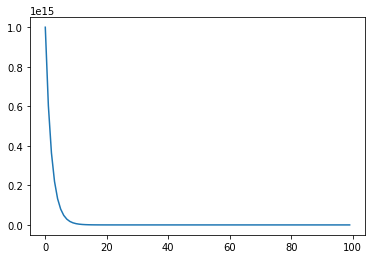

In [12]:
plt.plot(n.data[0])

In [13]:
# Create boundary conditions

x, = grid.dimensions
t = grid.stepping_dim

bc = [ Eq(n[t+1, 0], 1e15) ] # left

In [14]:
# Variable declarations

nt = 50 # time steps

dt = 1e-9 # size of the steps in s

In [15]:
# Create operator - create JIT-compiled and run C code

op = Operator([eq_stencil] + bc)

op(time=nt, dt=dt, D=0.9e-8, k1=1e7, k2=1e-11 * 1e-12)

Operator `Kernel` run in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=4.9999999999999996e-06, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

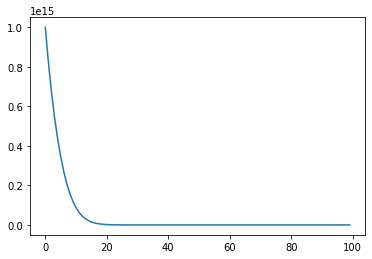

In [16]:
plt.plot(n.data[0])